Ratings DataFrame:
            item_1  item_2  item_3  item_4  item_5  item_6  item_7  item_8  \
customer_1     1.0     5.0     5.0     1.0     1.0     1.0     1.0     5.0   
customer_2     5.0     4.0     5.0     5.0     2.0     5.0     1.0     1.0   
customer_3     1.0     5.0     4.0     3.0     1.0     1.0     1.0     5.0   
customer_4     2.0     1.0     1.0     5.0     3.0     1.0     1.0     5.0   
customer_5     1.0     5.0     3.0     1.0     1.0     1.0     1.0     5.0   

            item_9  item_10  ...  item_41  item_42  item_43  item_44  item_45  \
customer_1     3.0      4.0  ...      1.0      1.0      1.0      5.0      1.0   
customer_2     1.0      1.0  ...      1.0      4.0      5.0      1.0      5.0   
customer_3     2.0      3.0  ...      1.0      1.0      1.0      5.0      1.0   
customer_4     1.0      1.0  ...      5.0      5.0      5.0      1.0      1.0   
customer_5     2.0      3.0  ...      1.0      1.0      1.0      5.0      1.0   

            item_46  item

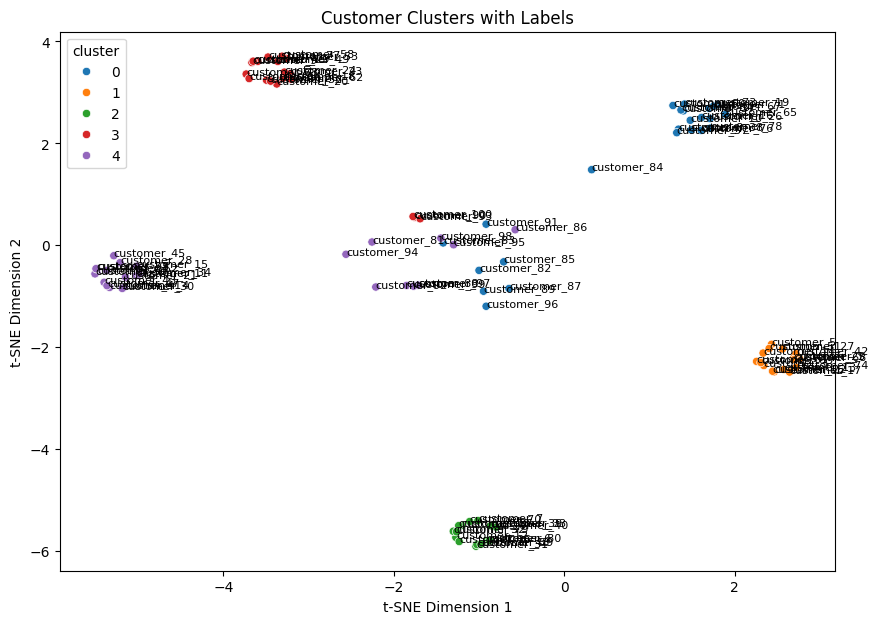

In [2]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data with clusters
num_customers = 100
num_items = 50
categories = ['Electronics', 'Clothing', 'Books', 'Home', 'Toys']
num_categories = len(categories)

# Create clusters of customer preferences using make_blobs
cluster_customers = 80  # Majority of customers in clusters
random_customers = num_customers - cluster_customers  # Rest of the customers scattered randomly

X_clusters, _ = make_blobs(n_samples=cluster_customers, centers=5, n_features=num_items, random_state=42)

# Generate random data for scattered customers
X_random = np.random.randint(1, 6, size=(random_customers, num_items))

# Combine clustered and random data
X = np.vstack((X_clusters, X_random))

# Normalize the ratings to be between 1 and 5
ratings = np.clip(np.round(X), 1, 5)

# Generate random categories and prices for items
item_categories = np.random.choice(categories, num_items)
item_prices = np.round(np.random.uniform(10, 100, num_items), 2)

# Convert to DataFrame
customers = [f'customer_{i+1}' for i in range(num_customers)]
items = [f'item_{j+1}' for j in range(num_items)]
ratings_df = pd.DataFrame(ratings, index=customers, columns=items)
item_df = pd.DataFrame({'item': items, 'category': item_categories, 'price': item_prices})

# Save dataframes to CSV
ratings_df.to_csv('customer_ratings.csv', index=False)
item_df.to_csv('item_details.csv', index=False)

# Display the first few rows of the DataFrames
print("Ratings DataFrame:")
print(ratings_df.head())
print("\nItem DataFrame:")
print(item_df.head())

# Perform SVD
svd = TruncatedSVD(n_components=20, random_state=42)
U = svd.fit_transform(ratings_df)
sigma = svd.singular_values_
VT = svd.components_

# Reconstruct the customer-item matrix
reconstructed_matrix = np.dot(np.dot(U, np.diag(sigma)), VT)

# Convert to DataFrame
reconstructed_df = pd.DataFrame(reconstructed_matrix, index=customers, columns=items)

# Function to get top 10 recommendations for a given customer
def get_top_10_recommendations(customer_id):
    customer_index = customers.index(customer_id)
    customer_ratings = reconstructed_df.iloc[customer_index]
    top_10_items = customer_ratings.sort_values(ascending=False).head(10).index.tolist()
    return top_10_items

# Function to get top 3 recommendations from each category for a given customer
def get_top_3_per_category(customer_id):
    customer_index = customers.index(customer_id)
    customer_ratings = reconstructed_df.iloc[customer_index]
    top_3_per_category = {}
    for category in categories:
        category_items = item_df[item_df['category'] == category]['item']
        category_ratings = customer_ratings[category_items]
        top_3_items = category_ratings.sort_values(ascending=False).head(3).index.tolist()
        top_3_per_category[category] = top_3_items
    return top_3_per_category

# Function to identify the category a customer is most interested in
def most_interested_category(customer_id):
    customer_index = customers.index(customer_id)
    customer_ratings = reconstructed_df.iloc[customer_index]
    category_interest = {category: 0 for category in categories}
    for category in categories:
        category_items = item_df[item_df['category'] == category]['item']
        category_ratings = customer_ratings[category_items]
        category_interest[category] = category_ratings.sum()
    most_interested = max(category_interest, key=category_interest.get)
    return most_interested

# Function to determine the price range a customer mostly prefers
def preferred_price_range(customer_id):
    customer_index = customers.index(customer_id)
    customer_ratings = reconstructed_df.iloc[customer_index]
    top_rated_items = customer_ratings.sort_values(ascending=False).head(10).index
    top_rated_prices = item_df[item_df['item'].isin(top_rated_items)]['price']
    avg_price = top_rated_prices.mean()
    return avg_price

# Example: Get recommendations and preferences for customer_1
customer_id = 'customer_1'
top_10_recommendations = get_top_10_recommendations(customer_id)
top_3_per_category = get_top_3_per_category(customer_id)
most_interested = most_interested_category(customer_id)
preferred_price = preferred_price_range(customer_id)

print(f"\nTop 10 recommendations for {customer_id}: {top_10_recommendations}")
print(f"Top 3 recommendations per category for {customer_id}: {top_3_per_category}")
print(f"Most interested category for {customer_id}: {most_interested}")
print(f"Preferred price range for {customer_id}: ${preferred_price:.2f}")

# Perform t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(U)

# Perform KMeans clustering to identify clusters
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(U)

# Create a DataFrame for t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['tsne_1', 'tsne_2'])
tsne_df['customer'] = customers
tsne_df['cluster'] = cluster_labels

# Plot the t-SNE results with cluster labels
plt.figure(figsize=(10, 7))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='cluster', palette='tab10', data=tsne_df)
for i, txt in enumerate(tsne_df['customer']):
    plt.annotate(txt, (tsne_df['tsne_1'][i], tsne_df['tsne_2'][i]), fontsize=8)
plt.title('Customer Clusters with Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()




Top 10 recommendations for 585: ['MacBook Air', 'HP Spectre x360', 'Samsung Refrigerator', 'Tempur-Pedic Mattress', 'Dyson Vacuum', 'Shark Upright Vacuum', 'LG Washing Machine', 'LEGO Mindstorms', 'Coleman Tent', 'Samsung Galaxy S21']
Top 3 recommendations per category for 585: {'Electronics': ['MacBook Air', 'HP Spectre x360', 'Samsung Galaxy S21'], 'Health and Beauty Products': ['The Ordinary Serum', 'Vitamin C Tablets', 'Olay Moisturizer'], 'Groceries and Food Items': ["Kellogg's Corn Flakes", 'Carrots', 'Starbucks Coffee'], 'Toys and Games': ['LEGO Mindstorms', 'Risk', 'Fisher-Price Learning Table'], 'Clothing and Apparel': ['Zara Dress', "Levi's Jeans", 'H&M Blouse'], 'Books and Media': ['The Godfather DVD', 'Inception Blu-ray', 'Harry Potter'], 'Automotive Parts and Accessories': ['Yoshimura Exhaust', 'Thule Roof Rack', 'Bridgestone Tires'], 'Sporting Goods and Outdoor Equipment': ['Coleman Tent', 'The North Face Backpack', 'Yeti Cooler'], 'Home and Kitchen Appliances': ['Samsun

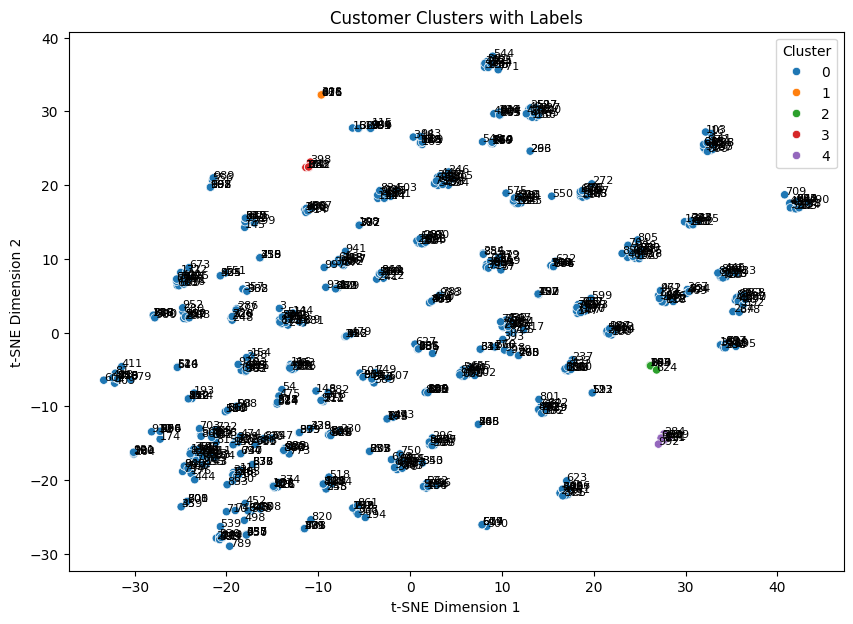

In [6]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load the order data
df = pd.read_csv('order_history.csv')

# Create a pivot table to summarize orders by Customer ID and Product Name
customer_product_matrix = df.pivot_table(index='Customer ID', columns='Product Name', values='Price Sold At', aggfunc='sum', fill_value=0)

# Perform SVD
svd = TruncatedSVD(n_components=20, random_state=42)
U = svd.fit_transform(customer_product_matrix)
sigma = svd.singular_values_
VT = svd.components_

# Reconstruct the customer-product matrix
reconstructed_matrix = np.dot(np.dot(U, np.diag(sigma)), VT)
reconstructed_df = pd.DataFrame(reconstructed_matrix, index=customer_product_matrix.index, columns=customer_product_matrix.columns)

# Function to get top 10 recommendations for a given customer
def get_top_10_recommendations(customer_id):
    customer_ratings = reconstructed_df.loc[customer_id]
    top_10_items = customer_ratings.sort_values(ascending=False).head(10).index.tolist()
    return top_10_items

# Function to get top 3 recommendations per category for a given customer
def get_top_3_per_category(customer_id):
    customer_ratings = reconstructed_df.loc[customer_id]
    top_3_per_category = {}
    for category in df['Industry'].unique():
        category_items = df[df['Industry'] == category]['Product Name'].unique()
        category_ratings = customer_ratings[category_items]
        top_3_items = category_ratings.sort_values(ascending=False).head(3).index.tolist()
        top_3_per_category[category] = top_3_items
    return top_3_per_category

# Function to identify the category a customer is most interested in
def most_interested_category(customer_id):
    customer_ratings = reconstructed_df.loc[customer_id]
    category_interest = {}
    for category in df['Industry'].unique():
        category_items = df[df['Industry'] == category]['Product Name'].unique()
        category_ratings = customer_ratings[category_items].sum()
        category_interest[category] = category_ratings
    most_interested = max(category_interest, key=category_interest.get)
    return most_interested

# Function to determine the price range a customer mostly prefers
def preferred_price_range(customer_id):
    customer_ratings = reconstructed_df.loc[customer_id]
    top_rated_items = customer_ratings.sort_values(ascending=False).head(10).index
    top_rated_prices = df[df['Product Name'].isin(top_rated_items)]['Price Sold At']
    avg_price = top_rated_prices.mean()
    return avg_price

# Example: Get recommendations and preferences for a specific customer
customer_id = 585
top_10_recommendations = get_top_10_recommendations(customer_id)
top_3_per_category = get_top_3_per_category(customer_id)
most_interested = most_interested_category(customer_id)
preferred_price = preferred_price_range(customer_id)

print(f"\nTop 10 recommendations for {customer_id}: {top_10_recommendations}")
print(f"Top 3 recommendations per category for {customer_id}: {top_3_per_category}")
print(f"Most interested category for {customer_id}: {most_interested}")
print(f"Preferred price range for {customer_id}: {preferred_price:.2f}")

# Perform t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(U)

# Perform KMeans clustering to identify clusters
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(U)

# Create a DataFrame for t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['tsne_1', 'tsne_2'])
tsne_df['Customer ID'] = customer_product_matrix.index
tsne_df['Cluster'] = cluster_labels

# Plot the t-SNE results with cluster labels
plt.figure(figsize=(10, 7))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='Cluster', palette='tab10', data=tsne_df)
for i, txt in enumerate(tsne_df['Customer ID']):
    plt.annotate(txt, (tsne_df['tsne_1'][i], tsne_df['tsne_2'][i]), fontsize=8)
plt.title('Customer Clusters with Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()
